In [2]:
import pandas as pd
!pip install numpy pandas
!pip install openpyxl #attribute to install excel reading
%pip install matplotlib seaborn plotly seaborn yfinance statsmodel.api
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas import to_datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#attribute'

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodel.api (from versions: none)
ERROR: No matching distribution found for statsmodel.api

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:

Inflation_diff = pd.read_csv('Inflation_diff.csv')
Interest_diff = pd.read_csv('Interest_diff.csv')
Current_account_diff = pd.read_csv('Current_account_diff.csv')
swaps_df = pd.read_csv('merged_df_month_year.csv')

In [10]:
# Data Preparation
inf = Inflation_diff[['USDEUR']]
int_diff = Interest_diff[['USDEUR']]
curr_acc = Current_account_diff[['USDEUR']]
USDEUR = swaps_df[['USDEUR_20Y', 'month-year', 'log_returns_USDEUR_20Y']]
dates = swaps_df['month-year']

#apply pct change to currencies, and differencing to the idv
inf = inf.diff().fillna(0.0)
int_diff = int_diff.diff().fillna(0.0)
curr_acc = curr_acc.diff().fillna(0.0)

USDEUR = USDEUR['USDEUR_20Y'].pct_change().fillna(0.0)

In [11]:
#combining factors
combined_factors = pd.concat([inf, int_diff, curr_acc], axis=1)
combined_factors.columns = ['Inflation', 'Interest_Rate_Diff', 'Current_Account_Diff']

In [13]:
#train and test split by indexing
train_size = int(len(combined_factors) * 0.8)
train_factors = combined_factors[:train_size]
test_factors = combined_factors[train_size:]
train_target = USDEUR[:train_size]
test_target = USDEUR[train_size:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

#realign all indices
train_factors = train_factors.align(train_target, join='inner', axis=0)[0]
test_factors = test_factors.align(test_target, join='inner', axis=0)[0]
train_target = train_target.align(train_factors, join='inner', axis=0)[0]
test_target = test_target.align(test_factors, join='inner', axis=0)[0]


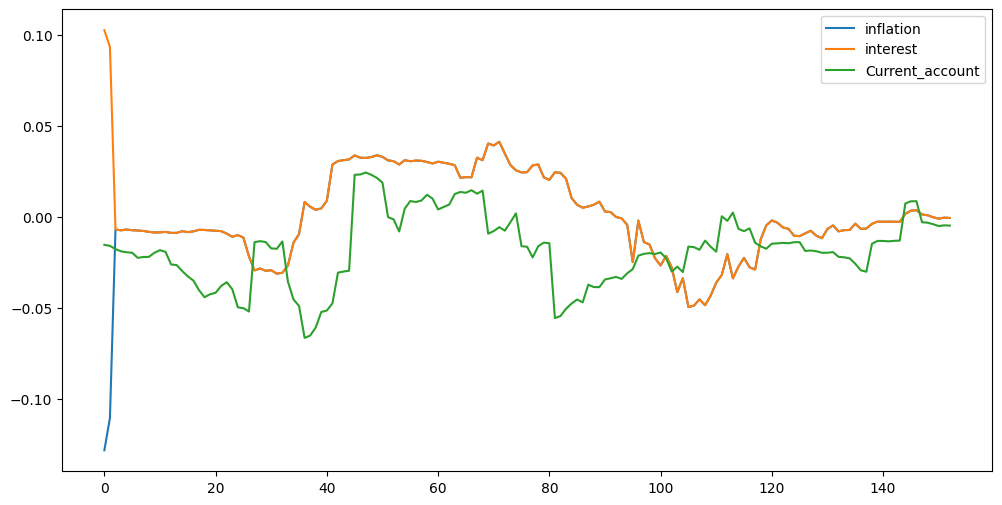

In [15]:
#rolling betas for the train set 
import statsmodels.api as sm

window = 36

train_betas = []

X = train_factors
Y = train_target

for start in range(len(X)-window+1):
    end = start + window
    X_window = X.iloc[start:end]
    Y_window = Y.iloc[start:end]
    X_window = sm.add_constant(X_window)
    model = sm.OLS(Y_window, X_window).fit()
    train_betas.append(model.params)

train_betas = np.array(train_betas)

plt.figure(figsize=(12, 6))
plt.plot(train_betas[:,1], label ='inflation')
plt.plot(train_betas[:,2], label = 'interest')
plt.plot(train_betas[:,3], label = 'Current_account')

plt.legend()
plt.show()

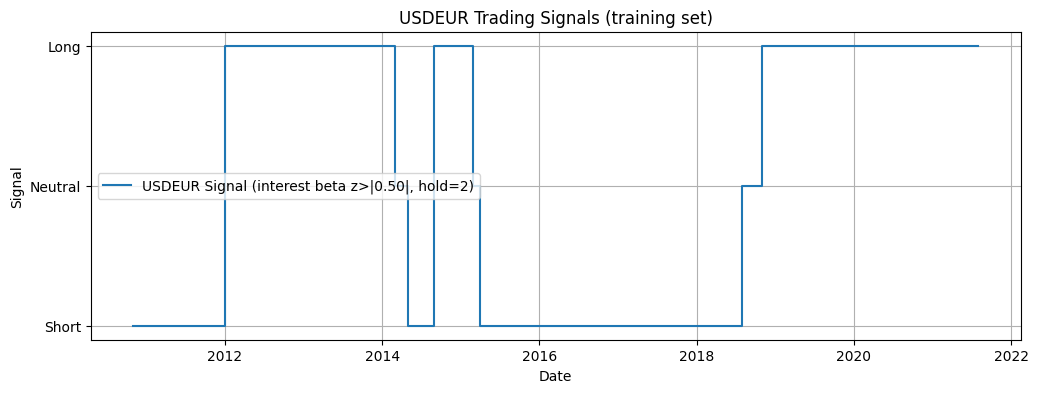

Best z: 0.5
            interest
month-year          
2021-06-01 -0.001005
2021-07-01 -0.000430
2021-08-01 -0.000633
        date  signal
0 2021-04-01       1
1 2021-05-01       1
2 2021-06-01       1
3 2021-07-01       1
4 2021-08-01       1


In [17]:
tr_betas_df = pd.DataFrame(train_betas, columns=['const', 'inflation', 'interest', 'Current_account'])
rain_dates = pd.DataFrame(train_dates, columns=['month-year'])

# ...existing code...
# USDCHF training signals from rolling interest beta

# 0) Preconditions: train_betas (rolling OLS params over window) already computed, and
#                   train_target (with ['USDCHF_20Y','month-year']) and `window` exist.

# 1) Align window-end dates for the betas

dates_train = pd.to_datetime(train_dates['month-year'] if isinstance(train_dates, pd.DataFrame) else train_dates)
assert len(dates_train) >= window, "Not enough rows for the chosen rolling window."

# If you created a DataFrame of params, prefer named columns to avoid mislabeling
if 'tr_betas_df' in globals():
    betas = tr_betas_df.copy()
#                   train_target (with ['USDCHF_20Y','month-year']) and `window` exist.

# 1) Align window-end dates for the betas

dates_train = pd.to_datetime(train_dates['month-year'] if isinstance(train_dates, pd.DataFrame) else train_dates)
assert len(dates_train) >= window, "Not enough rows for the chosen rolling window."

# If you created a DataFrame of params, prefer named columns to avoid mislabeling
if 'tr_betas_df' in globals():
    betas = tr_betas_df.copy()
else:
    betas = pd.DataFrame(train_betas, columns=['const','inflation','interest','Current_account'])

betas.index = dates_train[window-1:]  # align to window end

# 2) Take the interest beta series
interest_beta_train = betas['interest'].astype(float)

# 3) Smooth and standardize
beta_smooth = interest_beta_train.ewm(span=6, adjust=False).mean()
beta_z = (beta_smooth - beta_smooth.rolling(24).mean()) / (beta_smooth.rolling(24).std() + 1e-8)
beta_z = beta_z.dropna()

# 4) Build USDCHF train returns, align, and use next-period return (no look-ahead)
ret_train = train_target
ret_aligned = ret_train.reindex(beta_z.index)
ret_fwd = ret_aligned.shift(-1)  # t -> t+1 return

# 5) Pick a z-threshold on a calibration split inside train
z_grid = np.arange(0.5, 1.6, 0.25)
split = int(len(beta_z) * 0.7)
beta_cal, beta_val = beta_z.iloc[:split], beta_z.iloc[split:]
ret_cal, ret_val = ret_fwd.iloc[:split], ret_fwd.iloc[split:]

def sharpe_for(z):
    sig = np.sign(beta_cal.where(beta_cal.abs() >= z, 0)).astype(int)
    strat = (sig * ret_cal).dropna()
    return float(strat.mean() / (strat.std(ddof=0) + 1e-12))

best_z = max(z_grid, key=sharpe_for)

# 6) Final signals with a minimum holding period to reduce churn
raw_sig = np.sign(beta_z.where(beta_z.abs() >= best_z, 0)).astype(int)
min_hold = 2  # months
sig = raw_sig.replace(0, np.nan).ffill(limit=min_hold-1).fillna(0).astype(int)

usdchf_train_signals = sig.values
usdchf_train_signal_dates = sig.index.values

# 7) Plot
plt.figure(figsize=(12, 4))
plt.plot(usdchf_train_signal_dates, usdchf_train_signals, drawstyle='steps-post',
         label=f'USDEUR Signal (interest beta z>|{best_z:.2f}|, hold={min_hold})')
plt.title('USDEUR Trading Signals (training set)')
plt.xlabel('Date'); plt.ylabel('Signal'); plt.yticks([-1,0,1], ['Short','Neutral','Long'])
plt.legend(); plt.grid(True); plt.show()

# 8) Quick diagnostics
print("Best z:", best_z)
print(betas[['interest']].tail(3))
print(pd.DataFrame({'date': usdchf_train_signal_dates[-5:], 'signal': usdchf_train_signals[-5:]}))

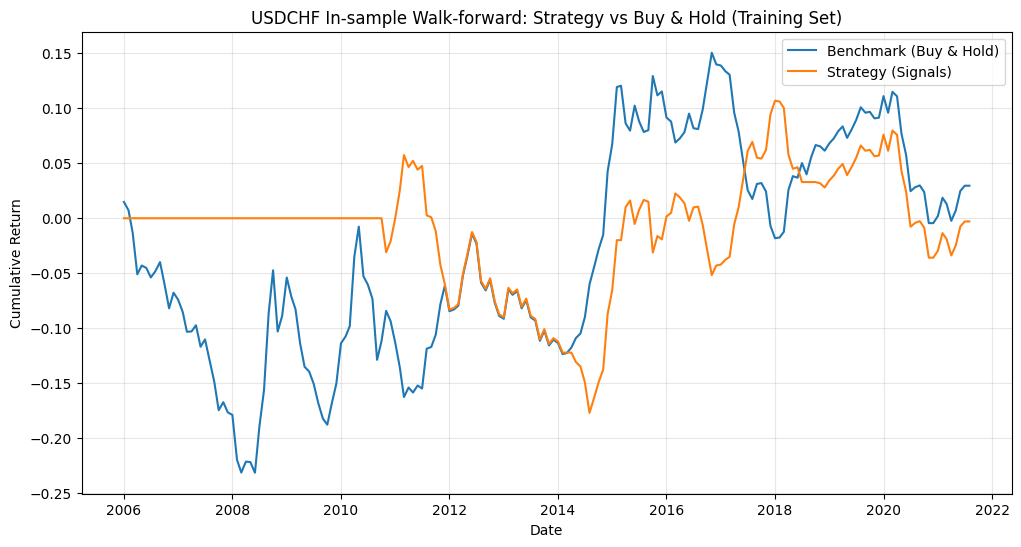

Train total return (strategy): -0.0029178876966597933
Train total return (benchmark): 0.02956197871974897
Train Sharpe (strategy): 0.021495608129741103
Train Sharpe (benchmark): 0.061964820496326546
Train hit rate (strategy): 0.3404255319148936
Avg turnover per period: 0.047872340425531915
          date   ret_fwd  signal  strat_ret  cum_strat  cum_bench
178 2020-11-01 -0.027559       1  -0.027559  -0.035853  -0.004446
179 2020-12-01 -0.000018       1  -0.000018  -0.035870  -0.004463
180 2021-01-01  0.006549       1   0.006549  -0.029556   0.002056
181 2021-02-01  0.016534       1   0.016534  -0.013511   0.018624
182 2021-03-01 -0.005584       1  -0.005584  -0.019020   0.012936
183 2021-04-01 -0.015111       1  -0.015111  -0.033843  -0.002371
184 2021-05-01  0.009311       1   0.009311  -0.024847   0.006919
185 2021-06-01  0.017752       1   0.017752  -0.007536   0.024793
186 2021-07-01  0.004653       1   0.004653  -0.002918   0.029562
187 2021-08-01  0.000000       1   0.000000  -0.0

In [20]:
# In-sample walk-forward test (training set) for USDCHF vs Buy & Hold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build full training date index and returns (no look-ahead: use next-period returns)
dates_train_full = pd.to_datetime(train_dates)
ret_train = train_target
ret_fwd_train = ret_train.shift(-1).fillna(0.0)  # t -> t+1

# 2) Align signals to full training dates; neutral (0) when signal missing
sig_series = pd.Series(usdchf_train_signals, index=pd.to_datetime(usdchf_train_signal_dates))
sig_full_train = sig_series.reindex(dates_train_full).fillna(0).astype(int)

# 3) Strategy and benchmark returns
strategy_returns_train = sig_full_train.values * ret_fwd_train.values
benchmark_returns_train = ret_fwd_train.values  # buy & hold

# 4) Cumulative (compounded) performance
cum_strat = np.cumprod(1.0 + strategy_returns_train) - 1.0
cum_bench = np.cumprod(1.0 + benchmark_returns_train) - 1.0

# 5) Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dates_train_full, cum_bench, label='Benchmark (Buy & Hold)')
plt.plot(dates_train_full, cum_strat, label='Strategy (Signals)')
plt.title('USDCHF In-sample Walk-forward: Strategy vs Buy & Hold (Training Set)')
plt.xlabel('Date'); plt.ylabel('Cumulative Return'); plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# 6) Summary stats
def sharpe_annualized(x):
    x = np.asarray(x)
    return float(np.mean(x) / (np.std(x) + 1e-12) * np.sqrt(12))

hit_rate = float(np.mean(strategy_returns_train > 0))
turnover = float(np.mean(np.abs(np.diff(sig_full_train.values, prepend=0)) > 0))

print('Train total return (strategy):', float(cum_strat[-1]))
print('Train total return (benchmark):', float(cum_bench[-1]))
print('Train Sharpe (strategy):', sharpe_annualized(strategy_returns_train))
print('Train Sharpe (benchmark):', sharpe_annualized(benchmark_returns_train))
print('Train hit rate (strategy):', hit_rate)
print('Avg turnover per period:', turnover)

# Inspect last few rows
out = pd.DataFrame({
    'date': dates_train_full,
    'ret_fwd': ret_fwd_train.values,
    'signal': sig_full_train.values,
    'strat_ret': strategy_returns_train,
    'cum_strat': cum_strat,
    'cum_bench': cum_bench,
})
print(out.tail(10))